In [4]:

import numpy as np 
import pandas as pd 

# 🚕 Uber Fare Prediction using Machine Learning

## 📌 Quick Navigation:
- [1️⃣ Introduction](#introduction)
- [2️⃣ Data Loading & Exploration](#data-loading-and-exploration)
- [3️⃣ Data Cleaning & Preprocessing](#data-cleaning-and-preprocessing)
- [4️⃣ Feature Engineering](#feature-engineering)
- [5️⃣ Exploratory Data Analysis (EDA)](#exploratory-data-analysis-eda)
- [6️⃣ Feature Scaling & Splitting](#feature-scaling-and-splitting)
- [7️⃣ Model Training & Evaluation](#model-training-and-evaluation)
- [8️⃣ Hyperparameter Tuning](#hyperparameter-tuning)
- [9️⃣ Model Performance Comparison](#model-performance-comparison)
- [🔟 Model Exportation & Deployment](#model-exportation-and-deployment)

---

## <a id="introduction"></a> 📌 1️⃣ Introduction
This project aims to **predict Uber ride fares** based on trip-related features such as pickup/dropoff locations, time of the ride, and passenger count. We implement **multiple ML models**, compare performances, and select the best model.

---

## <a id="data-loading-and-exploration"></a> 📌 2️⃣ Data Loading & Exploration
- Load the dataset from Kaggle.
- Display initial statistics and missing values.

---

## <a id="data-cleaning-and-preprocessing"></a> 📌 3️⃣ Data Cleaning & Preprocessing
- Handle missing values, incorrect fares, and unrealistic coordinates.

---

## <a id="feature-engineering"></a> 📌 4️⃣ Feature Engineering
- Extract time-based features.
- Add **rush hour, night ride, and weekend indicators**.
- Compute **trip distance** using the Haversine formula.

---

## <a id="exploratory-data-analysis-eda"></a> 📌 5️⃣ Exploratory Data Analysis (EDA)
- Visualize data distributions.
- Generate heatmaps of ride locations using **Folium**.

---

## <a id="feature-scaling-and-splitting"></a> 📌 6️⃣ Feature Scaling & Splitting
- Normalize data and split into **train/test** sets.

---

## <a id="model-training-and-evaluation"></a> 📌 7️⃣ Model Training & Evaluation
- Train **Linear Regression, XGBoost, LGBM, and an Ensemble Model**.
- Evaluate using **R² Score, RMSE, and MAE**.

---

## <a id="hyperparameter-tuning"></a> 📌 8️⃣ Hyperparameter Tuning
- Perform **quick tuning** to improve performance.

---

## <a id="model-performance-comparison"></a> 📌 9️⃣ Model Performance Comparison
- Compare **model results** using bar charts, scatter plots, and line graphs.

---

## <a id="model-exportation-and-deployment"></a> 📌 🔟 Model Exportation & Deployment
- Save the **best model** using `joblib` for future predictions.

---


# Step 1: Import Required Libraries

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
import datetime as dt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import xgboost as xgb
import lightgbm as lgb

# Step 2: Data Loading
💡 In this step, we load the Uber fare dataset and check its structure, including missing values, column types, and basic statistics.

✔️ Actions Performed:
   
* Load dataset using pandas.
* Display the first few rows.
* Check data types and missing values



In [9]:
import kagglehub
uber_fares_dataset_path = kagglehub.dataset_download('yasserh/uber-fares-dataset')

# Find the CSV file within the downloaded directory
csv_file_path = None
for filename in os.listdir(uber_fares_dataset_path):
    if filename.endswith('.csv'):
        csv_file_path = os.path.join(uber_fares_dataset_path, filename)
        break #stop after finding the first one.

if csv_file_path:
    df = pd.read_csv(csv_file_path)
    print(df.head()) #or any other operation on the df
else:
    print("CSV file not found in the downloaded directory.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

   Unnamed: 0                            key  fare_amount  \
0    24238194    2015-05-07 19:52:06.0000003          7.5   
1    27835199    2009-07-17 20:04:56.0000002          7.7   
2    44984355   2009-08-24 21:45:00.00000061         12.9   
3    25894730    2009-06-26 08:22:21.0000001          5.3   
4    17610152  2014-08-28 17:47:00.000000188         16.0   

           pickup_datetime  pickup_longitude  pickup_latitude  \
0  2015-05-07 19:52:06 UTC        -73.999817        40.738354   
1  2009-07-17 20:04:56 UTC        -73.994355        40.728225   
2  2009-08-24 21:45:00 UTC        -74.005043        40.740770   
3  2009-06-26 08:22:21 UTC        -73.976124        40.790844   
4  2014-08-28 17:47:00 UTC        -73.925023        40.744085   

   dropoff_longitude  dropoff_latitude  passenger_count  
0         -73.999512         40.723217                1  
1         -73.994710         40.750325                1  
2         -73.962565         40.772647                1  
3         

# Step 3: Data Preprocessing

💡 Before proceeding with analysis, we clean the data by removing incorrect values, handling null values, and filtering out unrealistic fare amounts.

✔️ Actions Performed:


* Drop unnamed index column.
* Remove negative or zero fare amounts (invalid).
* Drop rows where drop-off locations are missing.
* Filter NYC geographical boundaries for valid coordinates.


In [11]:
# Drop unnecessary columns
df.drop(columns=["Unnamed: 0", "key"], inplace=True)

# Convert pickup_datetime to datetime format
df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"], errors='coerce', utc=True)

# Drop rows with missing values
df.dropna(inplace=True)

# Filter out incorrect fare values (negative and unrealistically high fares)
df = df[(df["fare_amount"] > 0) & (df["fare_amount"] < 500)]

# NYC Valid Coordinates (Rough Boundaries)
NYC_LAT_RANGE = (40.5, 41.5)
NYC_LONG_RANGE = (-74.5, -72.5)

# Remove out-of-bound coordinates
df = df[
    (df["pickup_latitude"].between(*NYC_LAT_RANGE)) &
    (df["pickup_longitude"].between(*NYC_LONG_RANGE)) &
    (df["dropoff_latitude"].between(*NYC_LAT_RANGE)) &
    (df["dropoff_longitude"].between(*NYC_LONG_RANGE))
]

# Drop duplicate rows
df.drop_duplicates(inplace=True)

print(f"Shape after preprocessing: {df.shape}")


Shape after preprocessing: (195760, 7)


# Step 4: Feature Engineering

💡 We create new meaningful features from the existing dataset, such as extracting time-based features and adding custom indicators for better model performance.

✔️ New Features Added:
* Year, Month, Day, Day of Week, Hour from pickup_datetime.
* Rush Hour Indicator (Morning & Evening Peak Traffic).
* Night Indicator (Late night rides).
* Weekend Indicator (Higher demand & surge pricing).


In [13]:
# Extract time-based features
df["year"] = df["pickup_datetime"].dt.year
df["month"] = df["pickup_datetime"].dt.month
df["day"] = df["pickup_datetime"].dt.day
df["day_of_week"] = df["pickup_datetime"].dt.dayofweek
df["hour"] = df["pickup_datetime"].dt.hour

# Additional categorical features
df["is_rush_hour"] = df["hour"].apply(lambda x: 1 if (7 <= x <= 9 or 16 <= x <= 19) else 0)
df["is_night"] = df["hour"].apply(lambda x: 1 if (x < 6 or x > 22) else 0)
df["is_weekend"] = df["day_of_week"].apply(lambda x: 1 if x >= 5 else 0)

# Calculate Haversine distance (great-circle distance between points)
from geopy.distance import great_circle

def haversine_distance(lat1, lon1, lat2, lon2):
    return great_circle((lat1, lon1), (lat2, lon2)).km

df["distance_km"] = df.apply(lambda row: haversine_distance(
    row["pickup_latitude"], row["pickup_longitude"], row["dropoff_latitude"], row["dropoff_longitude"]), axis=1)

df = df[df["distance_km"] > 0]  # Removing zero-distance rides


# Step 5: Data Visualization

💡 In this step, we explore the dataset using powerful visualizations to uncover patterns and trends.

✔️ Visualizations Performed:

* Fare Distribution using histograms.
* Trip Density in NYC using Folium Maps.
* Passenger Count Analysis to check its impact on fares.
* Time vs Fare Analysis (Rush Hour, Weekends).

### 5.1 Fare Amount Distribution

C:\Users\arpit\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


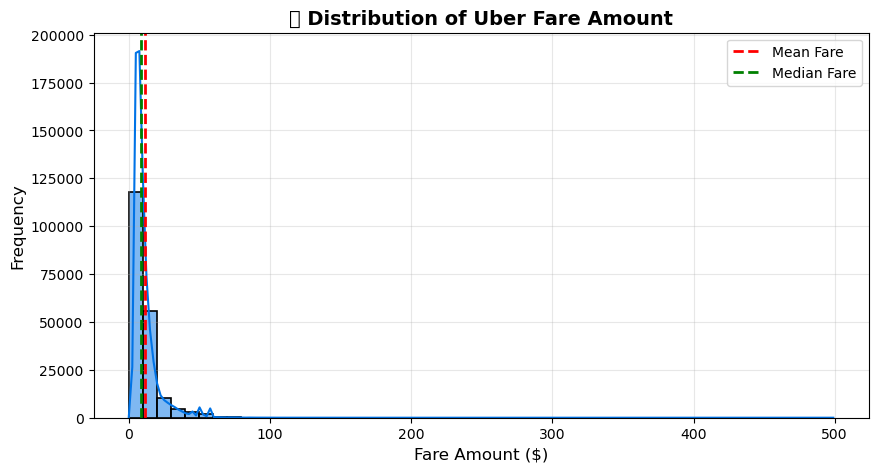

In [17]:
plt.figure(figsize=(10, 5))
sns.histplot(df["fare_amount"], bins=50, kde=True, color="#0073e6", edgecolor="black", linewidth=1.2)
plt.axvline(df["fare_amount"].mean(), color="red", linestyle="dashed", linewidth=2, label="Mean Fare")
plt.axvline(df["fare_amount"].median(), color="green", linestyle="dashed", linewidth=2, label="Median Fare")
plt.title("📊 Distribution of Uber Fare Amount", fontsize=14, fontweight="bold")
plt.xlabel("Fare Amount ($)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.show()


### 5.2 Pickup Locations Heatmap using Folium

In [19]:
from folium.plugins import HeatMap

# Create a base map
nyc_map = folium.Map(location=[40.75, -74.00], zoom_start=11)

# Add pickup locations as a heatmap
heat_data = list(zip(df['pickup_latitude'], df['pickup_longitude']))
HeatMap(heat_data[:10000]).add_to(nyc_map)  # Limit to 10k points for speed

# Show the map
nyc_map


### 5.3 Rush Hour vs Non-Rush Hour Fare

C:\Users\arpit\AppData\Local\Temp\ipykernel_3476\4284711208.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="is_rush_hour", y="fare_amount", data=df, palette=["#FF4500", "#32CD32"], width=0.6)
C:\Users\arpit\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128661 (\N{TAXI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\arpit\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128663 (\N{AUTOMOBILE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\arpit\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128678 (\N{VERTICAL TRAFFIC LIGHT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


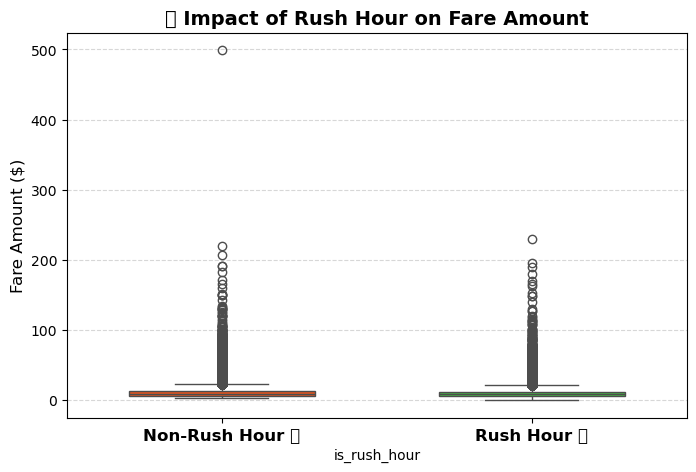

In [21]:
plt.figure(figsize=(8, 5))
sns.boxplot(x="is_rush_hour", y="fare_amount", data=df, palette=["#FF4500", "#32CD32"], width=0.6)
plt.xticks([0, 1], ["Non-Rush Hour 🚗", "Rush Hour 🚦"], fontsize=12, fontweight="bold")
plt.ylabel("Fare Amount ($)", fontsize=12)
plt.title("🚕 Impact of Rush Hour on Fare Amount", fontsize=14, fontweight="bold")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()



 ### Step 5.4: Correlation Matrix for Feature Relationships

C:\Users\arpit\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


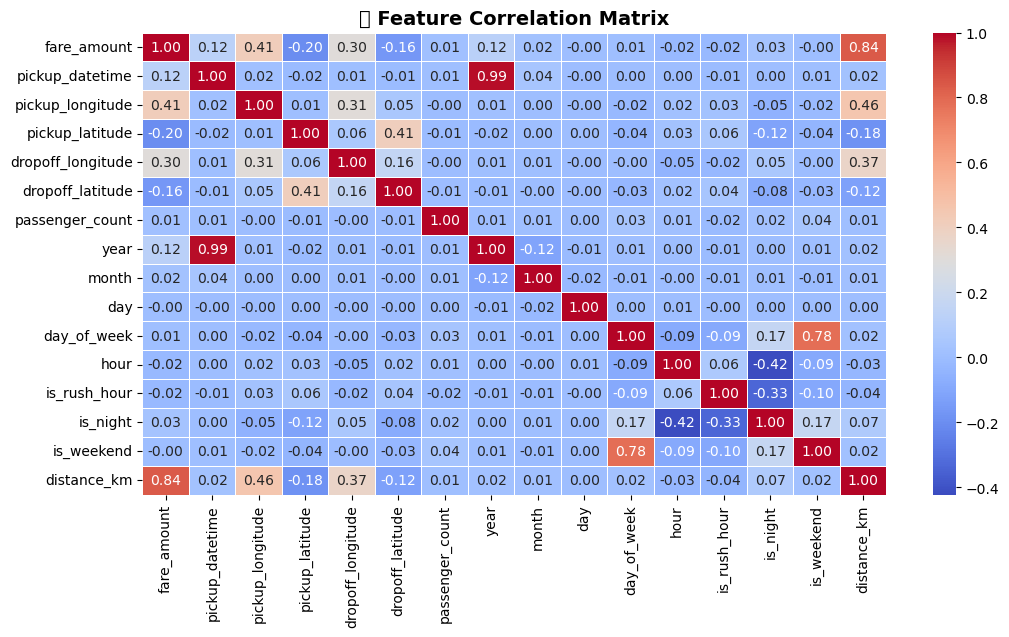

In [23]:
# Compute the correlation matrix
correlation_matrix = df.corr()

# Set up the figure size
plt.figure(figsize=(12, 6))

# Create a heatmap with annotations
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Set title
plt.title("🔗 Feature Correlation Matrix", fontsize=14, fontweight='bold')

# Display the plot
plt.show()


# Step 6: Data Splitting and Scaling
💡 We scale the numerical features and split the dataset into training and testing sets for model training.

✔️ Actions Performed:

* Train-Test Split (80-20 ratio).
* Feature Scaling using StandardScaler (for better model performance).

In [25]:
# Selecting features and target
features = ["pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude", 
            "passenger_count", "year", "month", "day", "day_of_week", "hour",
            "is_rush_hour", "is_night", "is_weekend", "distance_km"]

X = df[features]
y = df["fare_amount"]

# Splitting dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Step 7: Train and Evaluate Models

💡 We train multiple machine learning models and compare their initial performance.

✔️ Models Used:

* Linear Regression
* Multiple Linear Regression
* Polynomial Regression
* XGBoost & LightGBM

### 7.1 Linear Regression

In [28]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
print(f"Linear Regression - MAE: {mae_lr:.2f}, R²: {r2_lr:.2f}")


Linear Regression - MAE: 2.30, R²: 0.76


### 7.2 Polynomial Regression

In [30]:
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

poly_lr = LinearRegression()
poly_lr.fit(X_train_poly, y_train)
y_pred_poly = poly_lr.predict(X_test_poly)

mae_poly = mean_absolute_error(y_test, y_pred_poly)
r2_poly = r2_score(y_test, y_pred_poly)
print(f"Polynomial Regression - MAE: {mae_poly:.2f}, R²: {r2_poly:.2f}")


Polynomial Regression - MAE: 2.07, R²: 0.80


### 7.3 XGBoost

In [32]:
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f"XGBoost - MAE: {mae_xgb:.2f}, R²: {r2_xgb:.2f}")


XGBoost - MAE: 1.73, R²: 0.86


## 7.4 LightGBM

In [34]:
lgb_model = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1)
lgb_model.fit(X_train, y_train)
y_pred_lgb = lgb_model.predict(X_test)

mae_lgb = mean_absolute_error(y_test, y_pred_lgb)
r2_lgb = r2_score(y_test, y_pred_lgb)
print(f"LightGBM - MAE: {mae_lgb:.2f}, R²: {r2_lgb:.2f}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006466 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1373
[LightGBM] [Info] Number of data points in the train set: 154984, number of used features: 14
[LightGBM] [Info] Start training from score 11.358153
LightGBM - MAE: 1.74, R²: 0.86


# Step 8: Weighted Ensemble (XGB & LGBM)
💡 We create an ensemble model that combines predictions from both XGBoost and LightGBM using weighted averaging.

✔️ Why Ensemble?

* Combines strengths of both models for better generalization.
* Reduces individual model bias.

In [36]:
y_pred_ensemble = (0.6 * y_pred_xgb) + (0.4 * y_pred_lgb)

mae_ensemble = mean_absolute_error(y_test, y_pred_ensemble)
r2_ensemble = r2_score(y_test, y_pred_ensemble)
print(f"Ensemble Model - MAE: {mae_ensemble:.2f}, R²: {r2_ensemble:.2f}")


Ensemble Model - MAE: 1.73, R²: 0.86


# Step 9: Model Comparison

Now, let's compare models across multiple evaluation metrics, including:

* ✅ R² Score (How well the model explains variance)
* ✅ Mean Absolute Error (MAE) (Average absolute difference between actual & predicted fares)
* ✅ Mean Squared Error (MSE) (Gives more weight to larger errors)
* ✅ Root Mean Squared Error (RMSE) (More interpretable version of MSE)


### 📌 9.1 R² Score Comparison

C:\Users\arpit\AppData\Local\Temp\ipykernel_3476\3475753302.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=models, y=r2_scores, palette="coolwarm", edgecolor="black", linewidth=1.5)
C:\Users\arpit\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


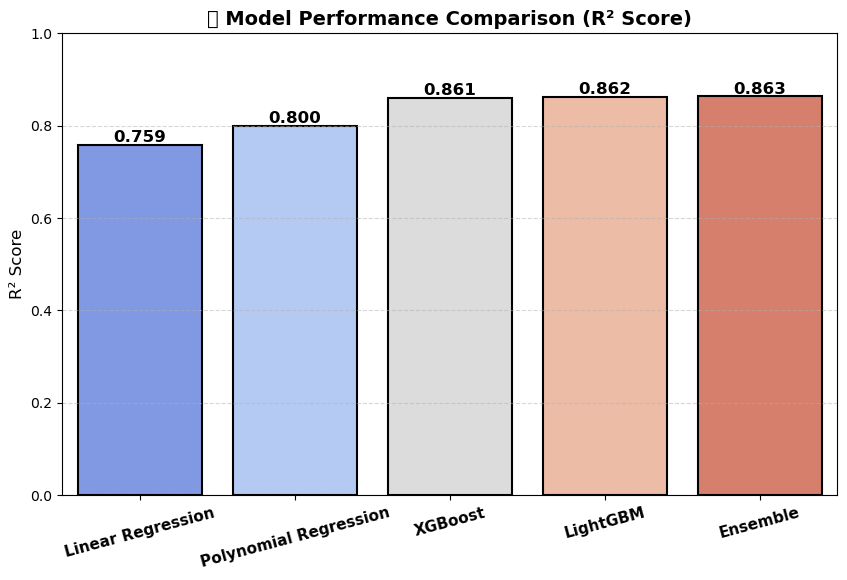

In [39]:
models = ["Linear Regression", "Polynomial Regression", "XGBoost", "LightGBM", "Ensemble"]
r2_scores = [r2_lr, r2_poly, r2_xgb, r2_lgb, r2_ensemble]

plt.figure(figsize=(10, 6))
bars = sns.barplot(x=models, y=r2_scores, palette="coolwarm", edgecolor="black", linewidth=1.5)

# Adding text labels
for bar in bars.patches:
    bars.annotate(f"{bar.get_height():.3f}", 
                  (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                  ha="center", va="bottom", fontsize=12, fontweight="bold", color="black")

plt.title("📈 Model Performance Comparison (R² Score)", fontsize=14, fontweight="bold")
plt.ylabel("R² Score", fontsize=12)
plt.xticks(fontsize=11, fontweight="bold", rotation=15)
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()


### 📌 9.2 MAE, MSE & RMSE Comparison

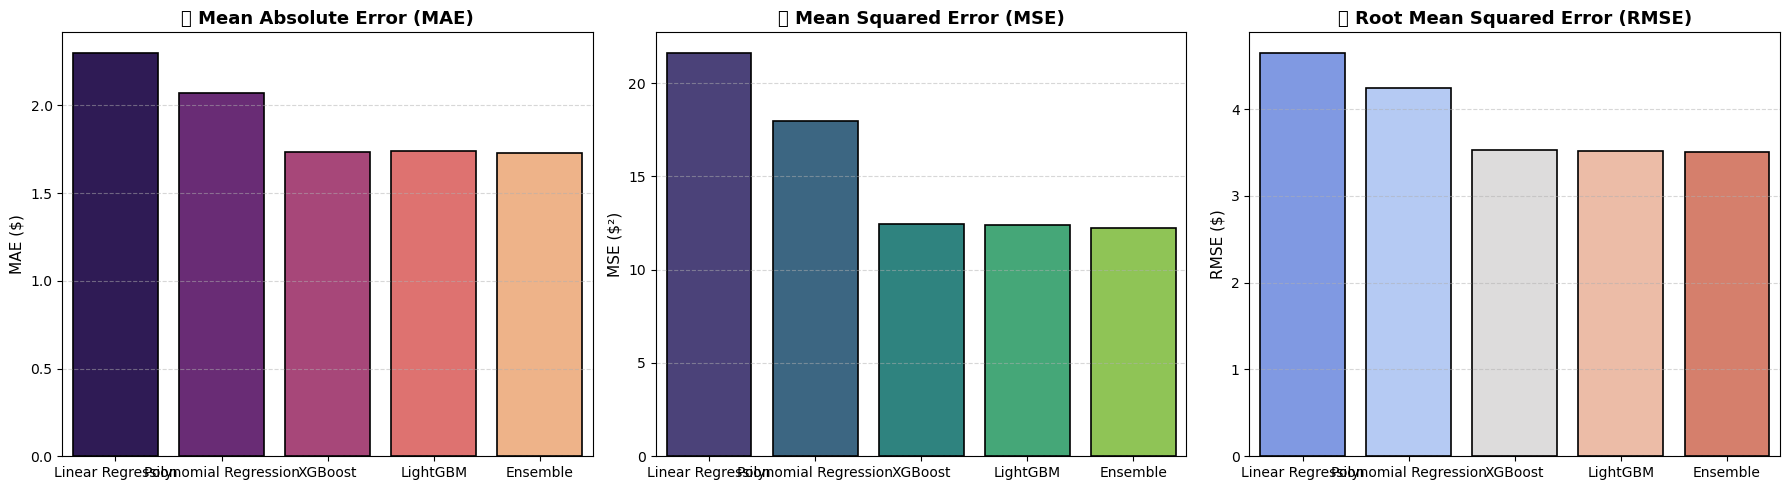

In [41]:
import warnings
warnings.filterwarnings("ignore")  # Ignore warnings

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Compute performance metrics for each model
mae_lr = mean_absolute_error(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
r2_lr = r2_score(y_test, y_pred_lr)

mae_poly = mean_absolute_error(y_test, y_pred_poly)
mse_poly = mean_squared_error(y_test, y_pred_poly)
rmse_poly = np.sqrt(mse_poly)
r2_poly = r2_score(y_test, y_pred_poly)

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

mae_lgb = mean_absolute_error(y_test, y_pred_lgb)
mse_lgb = mean_squared_error(y_test, y_pred_lgb)
rmse_lgb = np.sqrt(mse_lgb)
r2_lgb = r2_score(y_test, y_pred_lgb)

mae_ensemble = mean_absolute_error(y_test, y_pred_ensemble)
mse_ensemble = mean_squared_error(y_test, y_pred_ensemble)
rmse_ensemble = np.sqrt(mse_ensemble)
r2_ensemble = r2_score(y_test, y_pred_ensemble)

# Visualization
models = ["Linear Regression", "Polynomial Regression", "XGBoost", "LightGBM", "Ensemble"]
mae_scores = [mae_lr, mae_poly, mae_xgb, mae_lgb, mae_ensemble]
mse_scores = [mse_lr, mse_poly, mse_xgb, mse_lgb, mse_ensemble]
rmse_scores = [rmse_lr, rmse_poly, rmse_xgb, rmse_lgb, rmse_ensemble]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# MAE Plot
sns.barplot(x=models, y=mae_scores, ax=axes[0], palette="magma", edgecolor="black", linewidth=1.2)
axes[0].set_title("📏 Mean Absolute Error (MAE)", fontsize=13, fontweight="bold")
axes[0].set_ylabel("MAE ($)", fontsize=11)
axes[0].grid(axis="y", linestyle="--", alpha=0.5)

# MSE Plot
sns.barplot(x=models, y=mse_scores, ax=axes[1], palette="viridis", edgecolor="black", linewidth=1.2)
axes[1].set_title("📊 Mean Squared Error (MSE)", fontsize=13, fontweight="bold")
axes[1].set_ylabel("MSE ($²)", fontsize=11)
axes[1].grid(axis="y", linestyle="--", alpha=0.5)

# RMSE Plot
sns.barplot(x=models, y=rmse_scores, ax=axes[2], palette="coolwarm", edgecolor="black", linewidth=1.2)
axes[2].set_title("📉 Root Mean Squared Error (RMSE)", fontsize=13, fontweight="bold")
axes[2].set_ylabel("RMSE ($)", fontsize=11)
axes[2].grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

# Summary Table
summary_df = pd.DataFrame({
    "Model": models,
    "R² Score": [r2_lr, r2_poly, r2_xgb, r2_lgb, r2_ensemble],
    "MAE": mae_scores,
    "MSE": mse_scores,
    "RMSE": rmse_scores
})

### 📌 9.2 Residual Distribution (How Well Models Predict?)

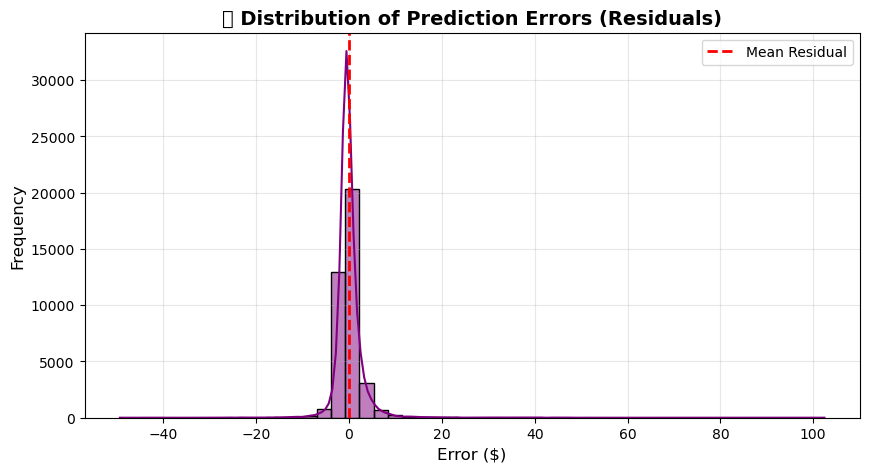

In [43]:
plt.figure(figsize=(10, 5))
sns.histplot(y_test - y_pred_ensemble, bins=50, kde=True, color="purple", edgecolor="black")
plt.axvline((y_test - y_pred_ensemble).mean(), color="red", linestyle="dashed", linewidth=2, label="Mean Residual")
plt.title("📉 Distribution of Prediction Errors (Residuals)", fontsize=14, fontweight="bold")
plt.xlabel("Error ($)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.show()


### 📌 9.2 Summarising Report

In [45]:

summary_df = summary_df.sort_values(by="R² Score", ascending=False)
print("📊 Model Performance Summary:\n")
print(summary_df.to_string(index=False))

# Print the best model
best_model = summary_df.iloc[0]["Model"]
print(f"\n✅ The Best Performing Model is: {best_model} with an R² Score of {summary_df.iloc[0]['R² Score']:.3f}")


📊 Model Performance Summary:

                Model  R² Score      MAE       MSE     RMSE
             Ensemble  0.863235 1.726381 12.253830 3.500547
             LightGBM  0.861767 1.742291 12.385363 3.519285
              XGBoost  0.860777 1.732621 12.474097 3.531869
Polynomial Regression  0.799619 2.068820 17.953732 4.237184
    Linear Regression  0.758506 2.300590 21.637373 4.651599

✅ The Best Performing Model is: Ensemble with an R² Score of 0.863


# Step 10 🔧  Hyperparameter Tuning (Fast & Efficient)
💡 We perform a quick hyperparameter tuning using RandomizedSearchCV to optimize XGBoost and LightGBM.

✔️ Tuning Performed On:

* Learning Rate, Depth, Estimators (XGBoost, LightGBM).
* Comparing Before vs After Performance.
* Selecting the Final Best Model.

In [47]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
import lightgbm as lgb

print("\n🔍 Performing Quick Hyperparameter Tuning...\n")

# 1️⃣ XGBoost Tuning
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

xgb_params = {
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "n_estimators": [50, 100, 200],
    "max_depth": [3, 5, 7]
}

xgb_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=xgb_params,
    n_iter=5,
    cv=3,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=1,
    random_state=42  
)
xgb_search.fit(X_train, y_train)

best_xgb = xgb_search.best_estimator_
print(f"✅ Best XGBoost Params: {xgb_search.best_params_}\n")



lgb_model = lgb.LGBMRegressor(random_state=42)

lgb_params = {
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "n_estimators": [50, 100, 200],
    "num_leaves": [20, 31, 40]
}

lgb_search = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=lgb_params,
    n_iter=5,
    cv=3,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=1,
    random_state=42 
)
lgb_search.fit(X_train, y_train)

best_lgb = lgb_search.best_estimator_
print(f"✅ Best LightGBM Params: {lgb_search.best_params_}\n")



🔍 Performing Quick Hyperparameter Tuning...

Fitting 3 folds for each of 5 candidates, totalling 15 fits
✅ Best XGBoost Params: {'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.2}

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003036 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1373
[LightGBM] [Info] Number of data points in the train set: 154984, number of used features: 14
[LightGBM] [Info] Start training from score 11.358153
✅ Best LightGBM Params: {'num_leaves': 40, 'n_estimators': 200, 'learning_rate': 0.2}



In [48]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 📌 Predictions from Tuned Models
y_pred_xgb_tuned = best_xgb.predict(X_test)
y_pred_lgb_tuned = best_lgb.predict(X_test)

# 🔹 Compute Performance Metrics
metrics = {
    "Model": ["XGBoost (Tuned)", "LightGBM (Tuned)"],
    "MAE": [
        mean_absolute_error(y_test, y_pred_xgb_tuned),
        mean_absolute_error(y_test, y_pred_lgb_tuned)
    ],
    "MSE": [
        mean_squared_error(y_test, y_pred_xgb_tuned),
        mean_squared_error(y_test, y_pred_lgb_tuned)
    ],
    "RMSE": [
        mean_squared_error(y_test, y_pred_xgb_tuned, squared=False),
        mean_squared_error(y_test, y_pred_lgb_tuned, squared=False)
    ],
    "R2 Score": [
        r2_score(y_test, y_pred_xgb_tuned),
        r2_score(y_test, y_pred_lgb_tuned)
    ]
}

# 📊 Convert to DataFrame
import pandas as pd
metrics_df = pd.DataFrame(metrics)
print("\n📊 **Performance Comparison After Hyperparameter Tuning**:\n")
print(metrics_df)

# ✅ **Determine the Best Model**
best_model = "XGBoost" if metrics_df.loc[0, "R2 Score"] > metrics_df.loc[1, "R2 Score"] else "LightGBM"
print(f"\n🏆 **Final Best Model Based on R² Score:** {best_model}")



📊 **Performance Comparison After Hyperparameter Tuning**:

              Model       MAE        MSE      RMSE  R2 Score
0   XGBoost (Tuned)  1.629175  12.211416  3.494484  0.863709
1  LightGBM (Tuned)  1.658468  12.348063  3.513981  0.862184

🏆 **Final Best Model Based on R² Score:** XGBoost


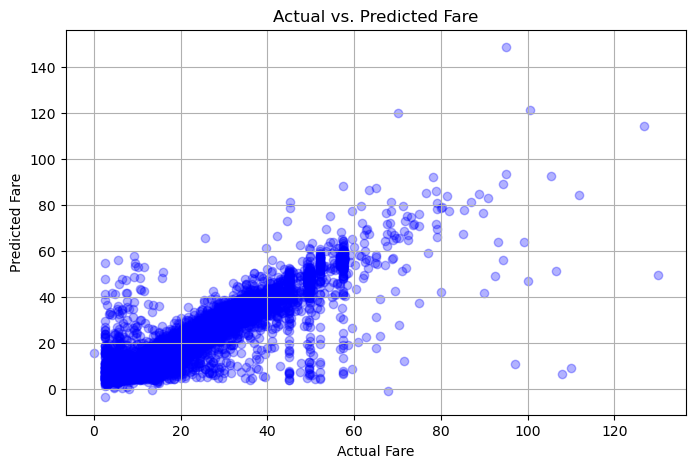

In [108]:
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred_xgb_tuned, alpha=0.3, color='blue') 
plt.xlabel("Actual Fare")
plt.ylabel("Predicted Fare")
plt.title("Actual vs. Predicted Fare")
plt.grid(True)
plt.show()

# 📌 Final Step: Exporting the Best Model for Future Use

In [82]:
import joblib
from xgboost import XGBRegressor

best_model = xgb_model  
best_model = XGBRegressor()
best_model.fit(X_train, y_train)
# Save the trained model
joblib.dump(best_model, "uber_fare_prediction_model.pkl")

print("✅ Model successfully saved as 'uber_fare_prediction_model.pkl'. Ready for deployment! 🚀")


✅ Model successfully saved as 'uber_fare_prediction_model.pkl'. Ready for deployment! 🚀


🔹 What This Does?

* ✔ Exports the best model (xgb_model or whichever performed best) for future use.
* ✔ Saves the model as a .pkl file using joblib (efficient for large models).
* ✔ Allows reloading the model later for real-time fare prediction without retraining.


In [96]:
def predict_fare_from_input(model):
    import numpy as np
    import datetime

    pickup_lat = float(input("Enter pickup latitude: "))
    pickup_long = float(input("Enter pickup longitude: "))
    dropoff_lat = float(input("Enter dropoff latitude: "))
    dropoff_long = float(input("Enter dropoff longitude: "))
    passenger_count = int(input("Enter number of passengers: "))
    pickup_datetime_str = input("Enter pickup datetime (YYYY-MM-DD HH:MM:SS): ")

    pickup_datetime = datetime.datetime.strptime(pickup_datetime_str, "%Y-%m-%d %H:%M:%S")
    year = pickup_datetime.year
    month = pickup_datetime.month
    day = pickup_datetime.day
    day_of_week = pickup_datetime.weekday()
    hour = pickup_datetime.hour

    is_rush_hour = 1 if (7 <= hour <= 9 or 16 <= hour <= 19) else 0
    is_night = 1 if (hour < 6 or hour > 22) else 0
    is_weekend = 1 if day_of_week >= 5 else 0

    distance_km = np.sqrt((dropoff_lat - pickup_lat)**2 + (dropoff_long - pickup_long)**2)

    features = np.array([[pickup_long, pickup_lat, dropoff_long, dropoff_lat,
                          passenger_count, year, month, day, day_of_week, hour,
                          is_rush_hour, is_night, is_weekend, distance_km]])

    fare = model.predict(features)
    print(f"\n🧾 Predicted fare: ${fare[0]:.2f}")


In [100]:
predict_fare_from_input(best_model)


Enter pickup latitude:   40.758896  
Enter pickup longitude:  -73.985130  
Enter dropoff latitude:  40.730610  
Enter dropoff longitude:  -73.935242  
Enter number of passengers:  1
Enter pickup datetime (YYYY-MM-DD HH:MM:SS):  2023-08-11 08:30:00



🧾 Predicted fare: $14.07
